### Key Points:

1. **Using VEM/FEM Solutions for Efficient Training**:
   - By training the neural network on the displacement field computed using VEM/FEM, you're providing the model with a high-quality reference solution. This allows the model to learn the underlying physical relationships between the parameters (such as Young’s modulus \(E\), cross-sectional area \(A\), and moment of inertia \(I\)) and the displacement field.

2. **Generalization with Fewer Data**:
   - Since the model is grounded in physically informed solutions, you likely need **fewer training examples** to generalize to new material and geometrical configurations. Unlike traditional machine learning models that require vast amounts of labeled data, your approach can rely on solving a **few instances** of VEM/FEM solutions and using that information to generalize.

3. **Parameter Sensitivity and Inference**:
   - The network’s sensitivity to material and geometrical parameters (\(E\), \(A\), \(I\)) is key. Once trained, the model will allow for **rapid inference** with new combinations of these parameters without needing to solve the full VEM/FEM system again.
   - In an engineering context, this is particularly advantageous, as engineers often need to explore various material or geometric configurations during design optimization. Having a trained neural network that provides **instant predictions** without solving a full VEM/FEM problem would significantly improve efficiency.

4. **Efficiency Compared to Traditional VEM/FEM**:
   - Solving a full VEM/FEM problem repeatedly for different parameter values can be computationally expensive, especially for large or complex systems. By training a neural network to approximate the displacement field based on these parameters, you essentially create a **surrogate model** that can make predictions more efficiently.

### Challenges and Considerations:
- **Accuracy vs. Efficiency**: While the neural network may provide fast predictions, the trade-off is the potential for reduced accuracy compared to solving the full VEM/FEM system. This can be mitigated by fine-tuning the network and introducing additional regularization techniques like Sobolev training.
  
- **Extrapolation Limits**: The network might struggle with extrapolating far beyond the range of material and geometrical parameters it was trained on. Ensuring that the training data includes a representative range of parameters will be crucial for reliable generalization.

- **Hybrid Model Validation**: You could validate your hypothesis by comparing the **computational cost** (in terms of time) and **accuracy** between solving multiple VEM/FEM instances and using the trained neural network for inference over a variety of material/geometrical configurations.

### Conclusion:
The approach of training a neural network using VEM/FEM solutions to enable efficient inference of displacement fields for different material and geometric configurations is a practical and promising solution in engineering contexts. It leverages the strengths of both numerical methods and machine learning to balance accuracy and efficiency.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem
from typing import Tuple

from utils.mesh import generate_portic_geometry, plot_nodes

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available!")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

MPS backend is available!


In [3]:
# Define the number of elements per edge and the length of the beam
num_elements_per_edge = 8
L = 2.0

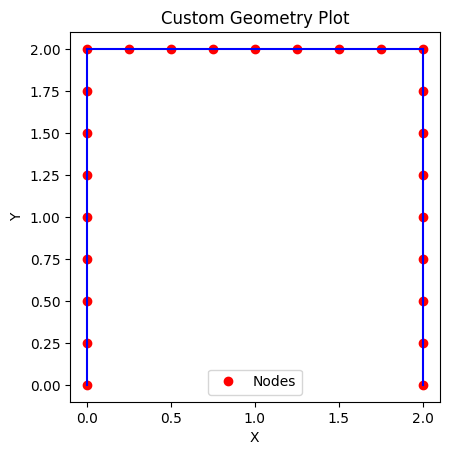

In [4]:
# Generate the geometry and the mesh
nodes, elements, supp = generate_portic_geometry(num_elements_per_edge, L)
plot_nodes(nodes, elements)

In [5]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [6]:
def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_loss_with_uh(uh_vem, uh):
    """
    Compute the loss function as (uh - uh_vem)^2 using PyTorch.

    Parameters:
    uh_vem (torch.Tensor): Solution vector from VEM (ndof x 1)
    uh (torch.Tensor): Solution vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    
    # Detach uh_vem if necessary to avoid tracking gradients
    uh_vem = torch.tensor(uh_vem, requires_grad=True)

    # Compute the loss (squared residual)
    loss = torch.sum((uh - uh_vem)**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

def compute_material_penalty(model, nodes, material_params_1, material_params_2, concatanate=False):
    """
    Computes a penalty for the model if the material parameters don't affect the predictions sufficiently.

    Parameters:
    mode (str): Material penalty mode ('l1' or 'l2')
    nodes (torch.Tensor): Node coordinates (nnodes x 3)
    material_params_1 (torch.Tensor): Material parameters for material 1 (nnodes x 1)
    material_params_2 (torch.Tensor): Material parameters for material 2 (nnodes x 1)

    Returns:
    torch.Tensor: Material penalty term as a scalar
    """
    if concatanate:
        input_1 = torch.cat((nodes, material_params_1))
        input_2 = torch.cat((nodes, material_params_2))

        uh_1 = model(input_1)
        uh_2 = model(input_2)
    else:
        uh_1 = model(nodes, material_params_1)
        uh_2 = model(nodes, material_params_2)
        

    penalty = torch.sum((uh_1 - uh_2) ** 2)
    return penalty

def normalize_loss_and_penalty(loss, material_penalty, beta=1e-4):
    """
    Normalizes the loss and material penalty by computing the scaling factor alpha.

    A factor beta is added to the loss and penalty to avoid division by zero.

    Parameters:
    loss (torch.Tensor): Loss term as a scalar
    material_penalty (torch.Tensor): Material penalty term as a scalar
    beta (float): Penalty factor (default: 1e-4)

    Returns:
    torch.Tensor: Normalized loss term as a scalar
    """
    loss_magnitude = loss.item() + beta
    penalty_magnitude = material_penalty.item() + beta

    alpha = loss_magnitude / penalty_magnitude
    
    return alpha


def compute_sobolev_loss(model, nodes, material_params, displacement_loss, concatanate=False):
    """
    Computes the Sobolev loss, includging both displacements and derivatives losses.

    Parameters:
    model (torch.nn.Module): Neural network model
    nodes (torch.Tensor): Node coordinates (nnodes x 3)
    material_params (torch.Tensor): Material parameters (nnodes x 1)
    uh_vem (torch.Tensor): Displacement field from VEM (ndof x 1)
    displacements_loss (torch.Tensor): Displacement loss as a scalar between uh and uh_vem

    Returns:
    torch.Tensor: Sobolev loss as a scalar
    """
    if concatanate:
        # Concatanete the nodes and material parameters
        input_vector = torch.cat((nodes, material_params))
        # Compute the displacement field from the neural network
        uh = model(input_vector)
    else:
        # Compute the displacement field from the neural network
        uh = model(nodes, material_params)

    # Compute the strain (first derivative)
    strain = torch.autograd.grad(uh, nodes, grad_outputs=torch.ones_like(uh), create_graph=True)[0]

    # Compute the curvature (second derivative)
    curvature = torch.autograd.grad(strain, nodes, grad_outputs=torch.ones_like(strain), create_graph=True)[0]

    # Compute the strain loss
    strain_loss = torch.sum(strain ** 2)

    # Compute the curvature loss
    curvature_loss = torch.sum(curvature ** 2)

    # Compute the total Sobolev loss
    sobolev_loss = displacement_loss + strain_loss + curvature_loss

    return sobolev_loss

In [7]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.sigmoid(layer(z))
            # z = torch.nn.functional.leaky_relu(layer(z), negative_slope=0.01)
        
        # Final output layer
        z = self.fout(z)
        
        return z
    
class ResidualBeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(ResidualBeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z_res = z
            z = torch.sigmoid(layer(z))

            # Residual block
            if z.shape == z_res.shape:
                z = z + z_res
        
        # Final output layer
        z = self.fout(z)
        
        return z
    
class BeamApproximatorWithMaterials(nn.Module):
    def __init__(self, input_dim_nodes, input_dim_materials, nodes_layers, material_layers, final_layers, ndof):
        super(BeamApproximatorWithMaterials, self).__init__()
        # Neural network for nodes
        self.nodes_in = nn.Linear(input_dim_nodes, nodes_layers[0])
        self.nodes_hidden = nn.ModuleList([nn.Linear(nodes_layers[i], nodes_layers[i+1]) for i in range(len(nodes_layers)-1)])
        self.nodes_out = nn.Linear(nodes_layers[-1], ndof)

        # Neural network for materials
        self.materials_in = nn.Linear(input_dim_materials, material_layers[0])
        self.materials_hidden = nn.ModuleList([nn.Linear(material_layers[i], material_layers[i+1]) for i in range(len(material_layers)-1)])
        self.materials_out = nn.Linear(material_layers[-1], ndof)

        # Final output layer
        self.final_in = nn.Linear(ndof*2, final_layers[0])
        self.final_hidden = nn.ModuleList([nn.Linear(final_layers[i], final_layers[i+1]) for i in range(len(final_layers)-1)])
        self.final_out = nn.Linear(final_layers[-1], ndof)  # Output layer

    def forward(self, x_nodes, x_materials):
        # Pass through the first layer
        z_nodes = torch.relu(self.nodes_in(x_nodes))
        z_materials = torch.relu(self.materials_in(x_materials))

        # Pass through the hidden layers
        for layer in self.nodes_hidden:
            z_nodes = torch.relu(layer(z_nodes))
        z_nodes = self.nodes_out(z_nodes)

        for layer in self.materials_hidden:
            z_materials = torch.relu(layer(z_materials))
        z_materials = self.materials_out(z_materials)

        # Concatenate the nodes and materials
        z_combined = torch.cat([z_nodes, z_materials])

        # Pass through the final layers
        z_combined = torch.relu(self.final_in(z_combined))
        for layer in self.final_hidden:
            z_combined = torch.relu(layer(z_combined))
        z_combined = self.final_out(z_combined)
        
        return z_combined

In [8]:
num_elements_per_edge = 64

# geometry data
L = 2.0
I = 1e-4
A = 1

# material data
E = 27e6

# Generate the geometry
nodes, elements, supp = generate_geometry(num_elements_per_edge, L)

# Plot the nodes
plot_nodes(nodes, elements)


# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

NameError: name 'generate_geometry' is not defined

The model refers to the disaplcement field and the loss function regards to the calculation of the residual taking in consideration the Virtual Element Method's stiffness matrix and load vector.

In [8]:
def normalize_inputs(nodes: torch.Tensor, material_params: torch.Tensor)->Tuple[torch.Tensor, torch.Tensor]:
    if(isinstance(nodes, np.ndarray)):
        nodes = torch.tensor(nodes, dtype=torch.float32)
    if(isinstance(material_params, np.ndarray)):
        material_params = torch.tensor(material_params, dtype=torch.float32)
    nodes = nodes.flatten()
    material_params = material_params.flatten()
    mu_nodes = torch.mean(nodes)
    sigma_nodes = torch.std(nodes)
    mu_material_params = torch.mean(material_params)
    sigma_material_params = torch.std(material_params)

    normalized_nodes = (nodes - mu_nodes) / sigma_nodes
    normalized_material_params = (material_params - mu_material_params) / sigma_material_params

    # Convert to tensor
    normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
    normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)

    return normalized_nodes, normalized_material_params

material_params = torch.tensor([E, A, I], dtype=torch.float32)
normalized_nodes, normalized_material_params = normalize_inputs(nodes, material_params)

/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)


In [9]:
def train(epochs, nodes, K, f, E, A, I, verbose=True, use_residual=False):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

    material_params = torch.tensor([E, A, I], dtype=torch.float32, requires_grad=True)

    input_vector = torch.cat([nodes, material_params])

    lr = 1e-3

    # Initialize the model and optimizer
    layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
    # layers = [128, 128, 256, 256, 512, 512, 512, 512]
    # layers = [128, 256, 512]
    if use_residual:
        model = ResidualBeamApproximator(input_dim, layers, ndof)
    else:
        model = BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    # uh = torch.linalg.solve(K, f)

    # epochs = 10000
    loss_buffer = float('inf')  # Initialize with a large value
    loss_values = []

    # Scaling factor for loss
    alpha = 1e-17

    # Original material parameters
    material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        uh = model(input_vector)
        
        # Compute the loss
        # loss = compute_loss_with_uh(uh_vem, uh)
        loss = alpha * compute_loss(K, uh, f)
        sobolev_loss = compute_sobolev_loss(model, nodes, material_params_1, loss, concatanate=True)
        total_loss = loss + sobolev_loss

        # total_loss = loss + penalty_coefficient*loss_bc
        
        # Only update the model if the new loss is smaller than the loss_buffer
        
        total_loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
        if epoch > 0:
            loss_values.append(total_loss.item())
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
        
        # Early stopping condition if the loss is not improving
        # if total_loss.item() >= loss_buffer:
        #     print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
        #     break
    
    if verbose:
        print("Training complete.")
        plt.plot(loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model

Given the reference displacement field calculated by the Virtual Element Method, a displacemente field is supposed to be calculated considering the material parameters contributions to it.

In [10]:
def train_material(epochs, nodes, K, f, E, A, I, verbose=True, noramlize_inputs=False, network_type='material'):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    input_dim_nodes = 2*len(nodes)
    input_dim_materials = 3

    # Original material parameters
    material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)
    print(f"Material params shape: {material_params_1.shape}")

    # Perturbed material parameters (slightly changed)
    material_params_2 = torch.tensor([E *1.1, A * 1.1, I * 0.9], dtype=torch.float32)

    if noramlize_inputs:
        nodes, material_params_1 = normalize_inputs(nodes, material_params_1)
        _, material_params_2 = normalize_inputs(nodes, material_params_2)

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)
    print(f"Nodes shape: {nodes.shape}")

    input_vector = torch.cat([nodes, material_params_1])

    lr = 1e-3

    # Initialize the model and optimizer
    if network_type == 'residual':
        # layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
        layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048]
        # layers = [128, 128, 256, 256, 512, 512, 512, 512]
        # layers = [128, 256, 512]
        concatanate=True
        model = ResidualBeamApproximator(input_dim, layers, ndof)
    if network_type == 'material':
        nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
        material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
        final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network
        # Concatanete the nodes and materials
        concatanate = False
        model = BeamApproximatorWithMaterials(
            input_dim_nodes=input_dim_nodes, 
            input_dim_materials=input_dim_materials, 
            nodes_layers=nodes_layers, 
            material_layers=material_layers, 
            final_layers=final_layers, 
            ndof=ndof)
    else:
        layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
        # layers = [128, 128, 256, 256, 512, 512, 512, 512]
        # layers = [128, 256, 512]
        concatanate=True
        model = BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

    total_loss_values = []
    loss_values = []
    material_loss_values = []
    sobolev_loss_values = []
    alpha_values_values = []

    # Scaling factor for loss
    # alpha = 1e-17

    for epoch in range(epochs):
        optimizer.zero_grad()
        # uh = model(input_vector)
        uh = model(nodes, material_params_1)
        
        # Compute the loss
        loss = compute_loss_with_uh(uh_vem, uh)
        # Compute the sobolev loss
        sobolev_loss = compute_sobolev_loss(model, nodes, material_params_1,loss, concatanate)
        # Compute material penalty
        material_penalty = compute_material_penalty(model, nodes, material_params_1, material_params_2, concatanate)
        # Normalize the loss and penalty
        alpha = normalize_loss_and_penalty(loss, material_penalty)
        total_loss = loss + alpha * material_penalty + sobolev_loss
        
        total_loss.backward()
        
        optimizer.step()
        if epoch > 0:
            total_loss_values.append(total_loss.item())
            loss_values.append(loss.item())
            material_loss_values.append(material_penalty.item())
            sobolev_loss_values.append(sobolev_loss.item())
            alpha_values_values.append(alpha)
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
    
    if verbose:
        print("Training complete.")
        plt.plot(total_loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model, total_loss_values, loss_values, material_loss_values, sobolev_loss_values, alpha_values_values

Material params shape: torch.Size([3])
Nodes shape: torch.Size([386])


/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/1770968435.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch: 1, Total Loss: 0.5055776395684809
Epoch: 2, Total Loss: 0.15461497252482487
Epoch: 3, Total Loss: 0.16571119157176536
Epoch: 4, Total Loss: 0.01495990765672554
Epoch: 5, Total Loss: 0.016015687683116533
Epoch: 6, Total Loss: 0.020025089673819697
Epoch: 7, Total Loss: 0.023983221814331226
Epoch: 8, Total Loss: 0.024182055728689644
Epoch: 9, Total Loss: 0.018817508964203637
Epoch: 10, Total Loss: 0.013258634600229387
Epoch: 11, Total Loss: 0.009113555442379958
Epoch: 12, Total Loss: 0.006105953702914998
Epoch: 13, Total Loss: 0.004530078131821217
Epoch: 14, Total Loss: 0.0034879630247886687
Epoch: 15, Total Loss: 0.003163290734392697
Epoch: 16, Total Loss: 0.0028571924644254557
Epoch: 17, Total Loss: 0.002747576912040437
Epoch: 18, Total Loss: 0.00258760376974372
Epoch: 19, Total Loss: 0.00251826080971253
Epoch: 20, Total Loss: 0.002281388421023537
Epoch: 21, Total Loss: 0.00205515212673472
Epoch: 22, Total Loss: 0.0016659901684473709
Epoch: 23, Total Loss: 0.0013906988778398964
E

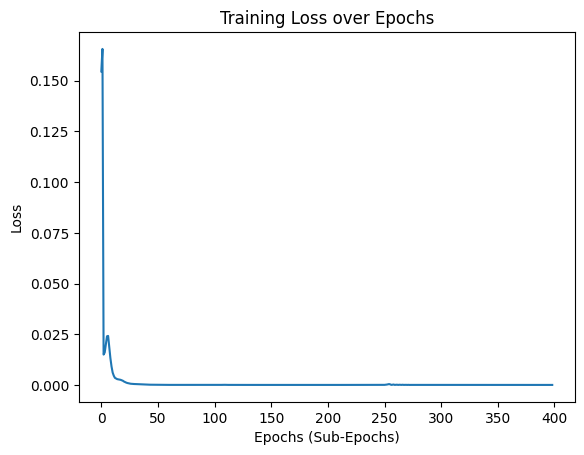

In [11]:
input_vector, model, total_loss_values, loss_values, material_loss_values, sobolev_loss_values, alpha_values_values = train_material(
    epochs=400, 
    nodes=nodes, 
    K=K, 
    f=f, 
    E=E, 
    A=A, 
    I=I,
    verbose=True,
    noramlize_inputs=True, 
    network_type='material')
# input_vector, model = train(epochs=3000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, use_residual=False)

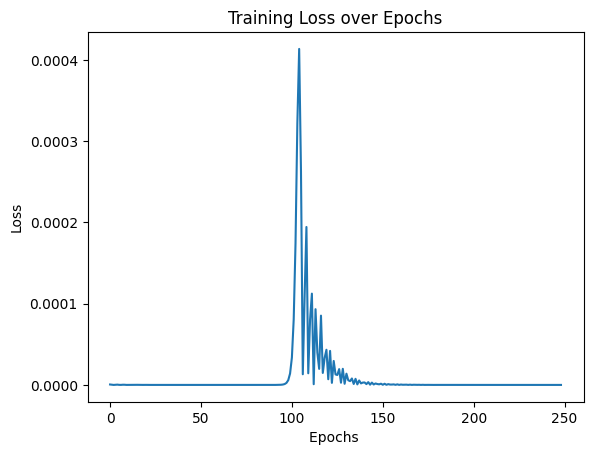

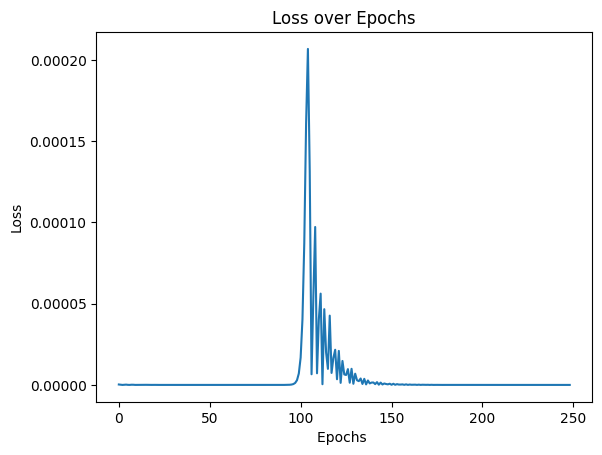

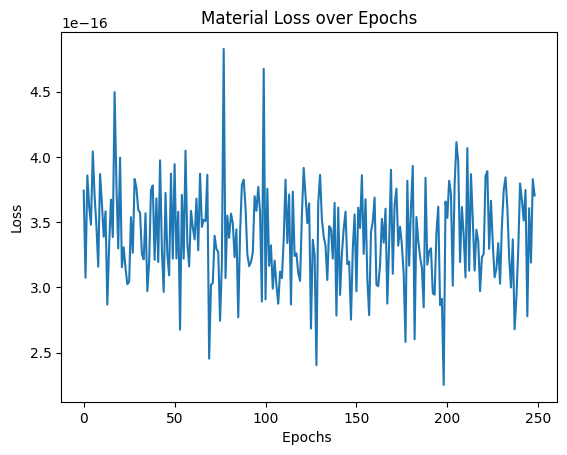

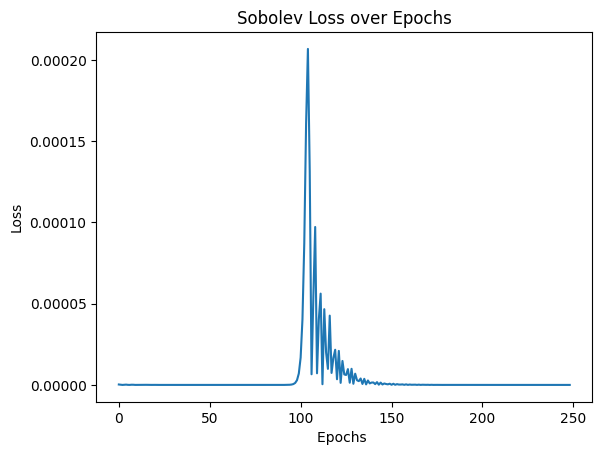

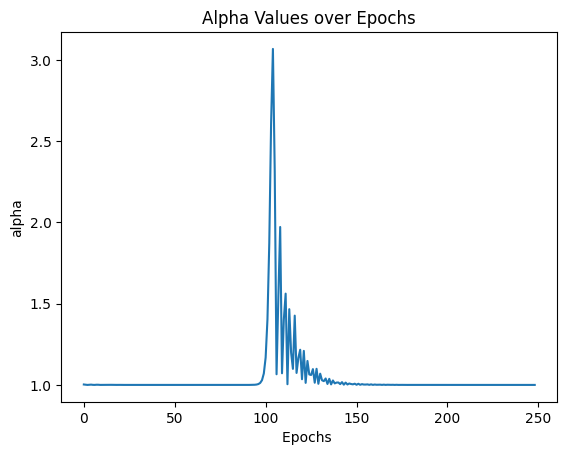

In [12]:
filtered_total_loss = total_loss_values[150:]
plt.plot(filtered_total_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

filtered_loss = loss_values[150:]
plt.plot(filtered_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

filtered_material_loss = material_loss_values[150:]
plt.plot(filtered_material_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Material Loss over Epochs')
plt.show()

filtered_sobolev_loss = sobolev_loss_values[150:]
plt.plot(filtered_sobolev_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Sobolev Loss over Epochs')
plt.show()

filtered_alpha_values = alpha_values_values[150:]
plt.plot(filtered_alpha_values)
plt.xlabel('Epochs ')
plt.ylabel('alpha')
plt.title('Alpha Values over Epochs')
plt.show()

In [13]:
def test(nodes, material_params, model, uh_vem, K, f, concatanate=False):
    # Set the model to evaluation mode
    model.eval()

    # Ensure nodes and material_params are torch tensors
    if isinstance(nodes, np.ndarray):
        nodes = torch.tensor(nodes, dtype=torch.float32)
    if isinstance(material_params, np.ndarray):
        material_params = torch.tensor(material_params, dtype=torch.float32)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    uh_vem = torch.tensor(uh_vem, dtype=torch.float32)

    # Ensure gradients are not tracked during prediction
    with torch.no_grad():
        # Use the trained model to make predictions
        if concatanate:
            input_vector = torch.cat((nodes, material_params))
            predicted_displacements = model(input_vector)
        else:
            predicted_displacements = model(nodes, material_params)

    # Print or use the predicted displacements
    print("Predicted displacements:", predicted_displacements)

    # Compute errors and ensure tensors are on the same device
    l2_error = compute_l2_error(uh_vem, predicted_displacements).item()
    energy_error = compute_energy_error(K, uh_vem, predicted_displacements).item()
    h1_error = compute_h1_norm(K, uh_vem, predicted_displacements).item()

    return predicted_displacements, l2_error, energy_error, h1_error

In [14]:
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
# nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error = test(nodes, material_params, model, uh_vem, K, f, concatanate=False)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-1.8999e-07,  1.8813e-07,  1.8999e-07, -1.8440e-07,  7.5437e-08,
         1.0617e-07,  4.7497e-08,  1.2852e-07,  9.6858e-08, -2.0047e-07,
        -2.3004e-07,  1.9185e-07,  1.6205e-07, -3.3528e-07, -9.2201e-08,
         2.1327e-07,  3.7253e-09, -2.0675e-07, -1.1642e-07, -8.8883e-08,
        -1.5646e-07,  5.2154e-08,  1.5646e-07,  1.5274e-07,  1.0431e-07,
        -2.0303e-07, -1.5832e-08,  8.1025e-08, -2.0117e-07,  6.5193e-08,
         4.8429e-08,  1.5087e-07, -9.7789e-08,  2.4028e-07, -3.3062e-08,
         8.4867e-08,  7.3574e-08, -2.0023e-07, -2.1420e-08, -1.2200e-07,
        -2.2259e-07, -7.9162e-08,  5.1223e-09,  1.0058e-07, -4.1910e-08,
         9.4995e-08,  1.3970e-08,  3.0268e-09,  1.9372e-07, -1.4019e-07,
         1.1967e-07,  5.2154e-08,  5.2154e-08, -1.7323e-07, -7.3574e-08,
         5.9605e-08, -1.7695e-08,  1.6717e-07, -3.9674e-07, -2.9802e-07,
        -1.6764e-07,  6.9849e-08, -1.0245e-07,  1.8254e-07,  5.5879e-08,
        -1.7229e-08, -1.30

/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/787023990.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consi

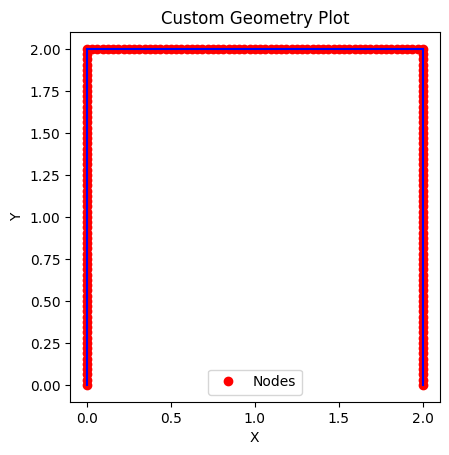


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.45561955e-10
 -1.42471523e-08  3.49159651e-08  1.14478574e-09 -2.84943045e-08
 -1.43098218e-07  3.17457532e-09 -3.91903204e-08  1.31916843e-08
 -1.68029101e-10 -4.27840636e-08  2.00734999e-07 -2.66399934e-09
 -4.28266704e-08 -4.09929035e-08 -1.25588321e-09 -4.28692772e-08
 -4.91265291e-08 -2.13198021e-10 -4.29118840e-08 -1.76053228e-08
  8.16002787e-11 -4.29544908e-08 -1.26176837e-09  7.04721302e-11
 -4.29970976e-08  1.97396987e-09  2.19136200e-11 -4.30397044e-08
  1.13377478e-09  2.03957399e-13 -4.30823112e-08  2.55643623e-10
 -3.11391138e-12 -4.31249180e-08 -4.33000213e-11 -1.52666687e-12
 -4.31675248e-08 -5.82836272e-11 -2.77411316e-13 -4.32101316e-08
 -2.16687284e-11  9.04243133e-14 -4.32527384e-08 -1.87275187e-12
  8.41255472e-14 -4.32953452e-08  2.27587290e-12  2.71830783e-14
 -4.33379520e-08  1.36844510e-12  7.35617950e-16 -4.33805588e-08
  3.24192363e-13 -3.63071773e-1

In [15]:
num_elements_per_edge = 64

# geometry data
L = 2.0
I = 1e-4
A = 5

# material data
E = 110e5

# Generate the geometry
nodes, elements, supp = generate_geometry(num_elements_per_edge, L)

# Plot the nodes
plot_nodes(nodes, elements)


# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

In [16]:
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error = test(nodes, material_params, model, uh_vem, K, f, concatanate=False)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-1.8999e-07,  1.8626e-07,  1.9185e-07, -1.8626e-07,  7.4506e-08,
         1.0617e-07,  4.7497e-08,  1.2852e-07,  9.6858e-08, -2.0000e-07,
        -2.3004e-07,  1.9372e-07,  1.6205e-07, -3.3528e-07, -9.2201e-08,
         2.1234e-07,  3.2596e-09, -2.0675e-07, -1.1828e-07, -8.9814e-08,
        -1.5646e-07,  5.2387e-08,  1.5646e-07,  1.5460e-07,  1.0431e-07,
        -2.0303e-07, -1.4901e-08,  8.1491e-08, -2.0117e-07,  6.5193e-08,
         4.8429e-08,  1.5087e-07, -9.7789e-08,  2.4028e-07, -3.3528e-08,
         8.4867e-08,  7.3574e-08, -2.0023e-07, -1.9558e-08, -1.2154e-07,
        -2.2259e-07, -7.9162e-08,  5.1223e-09,  1.0058e-07, -4.1910e-08,
         9.4995e-08,  1.3271e-08,  3.0268e-09,  1.9744e-07, -1.3996e-07,
         1.1921e-07,  5.1223e-08,  5.2154e-08, -1.7323e-07, -7.2643e-08,
         5.9605e-08, -1.8626e-08,  1.6717e-07, -3.9674e-07, -2.9802e-07,
        -1.6578e-07,  6.8918e-08, -1.0245e-07,  1.8254e-07,  5.5879e-08,
        -1.7229e-08, -1.30

/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_7101/3907548546.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)
